<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S12/EVA4_S12_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount and Fetch Data

Original tiny-imagenet-200.zip file was remodified to combine the original train & val images and split 70% - 30% into new_train and new_test

script: **python data/prepare_tiny-imagenet-200.py**

In [15]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [16]:
import zipfile

path_to_zip_file = "/content/gdrive/My Drive/EVA4-Workspace/data/tiny-imagenet-200.zip"
directory_to_extract_to = '/content/data'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/data/tiny-imagenet-200.zip
Extracted at: /content/data


## Imports and Initialization

Import required modules

In [0]:
# !pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18
from mtrain import train
from mtest import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

## Model Configuration and Set Seed

View model configuration and set the seed

In [4]:
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 256,
  'dropout': 0,
  'epochs': 15,
  'l1_decay': 0,
  'l2_decay': 0.005,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1,
  'test_data_path': '/content/data/tiny-imagenet-200/new_test',
  'train_data_path': '/content/data/tiny-imagenet-200/new_train'}

CUDA Available


## Data Loading and Visualization

Preprocess and load the tiny-imagenet-200 dataset. Visualise the dataset.

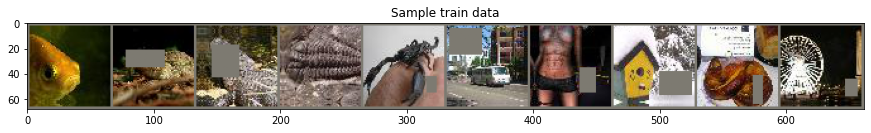

In [5]:
data = DataEngine(args)
data.show_samples()

## Model

Create model and display model summary

In [6]:
device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Training and Testing

Train the model and evaluate it

In [7]:
epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=7/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.001000)


L2_loss=464.331 Loss=6.83692 Batch_id=300 Accuracy=4.57: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 4.5242, Accuracy: 2446/33000 (7.41%)

EPOCH: 2 (LR: 0.001446)


L2_loss=463.002 Loss=6.29692 Batch_id=300 Accuracy=10.66: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 4.1591, Accuracy: 3808/33000 (11.54%)

EPOCH: 3 (LR: 0.002696)


L2_loss=461.412 Loss=5.75774 Batch_id=300 Accuracy=16.26: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.8162, Accuracy: 5232/33000 (15.85%)

EPOCH: 4 (LR: 0.004501)


L2_loss=459.685 Loss=5.71194 Batch_id=300 Accuracy=21.16: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 4.2887, Accuracy: 4620/33000 (14.00%)

EPOCH: 5 (LR: 0.006505)


L2_loss=457.858 Loss=5.46265 Batch_id=300 Accuracy=25.67: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.4312, Accuracy: 7162/33000 (21.70%)

EPOCH: 6 (LR: 0.008309)


L2_loss=456.024 Loss=5.17877 Batch_id=300 Accuracy=29.56: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.1924, Accuracy: 8925/33000 (27.05%)

EPOCH: 7 (LR: 0.009557)


L2_loss=454.205 Loss=5.34171 Batch_id=300 Accuracy=33.05: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 3.1051, Accuracy: 9224/33000 (27.95%)

EPOCH: 8 (LR: 0.010000)


L2_loss=452.381 Loss=4.79960 Batch_id=300 Accuracy=36.22: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.9935, Accuracy: 10117/33000 (30.66%)

EPOCH: 9 (LR: 0.009924)


L2_loss=450.557 Loss=4.57556 Batch_id=300 Accuracy=39.22: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.8688, Accuracy: 11047/33000 (33.48%)

EPOCH: 10 (LR: 0.009700)


L2_loss=448.762 Loss=4.68172 Batch_id=300 Accuracy=41.61: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.7497, Accuracy: 11660/33000 (35.33%)

EPOCH: 11 (LR: 0.009335)


L2_loss=446.995 Loss=4.62795 Batch_id=300 Accuracy=43.83: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.6352, Accuracy: 12445/33000 (37.71%)

EPOCH: 12 (LR: 0.008840)


L2_loss=445.254 Loss=4.63651 Batch_id=300 Accuracy=45.68: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.4782, Accuracy: 13411/33000 (40.64%)

EPOCH: 13 (LR: 0.008230)


L2_loss=443.565 Loss=4.50632 Batch_id=300 Accuracy=47.72: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.6422, Accuracy: 12475/33000 (37.80%)

EPOCH: 14 (LR: 0.007523)


L2_loss=441.944 Loss=4.24640 Batch_id=300 Accuracy=50.02: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.5348, Accuracy: 13247/33000 (40.14%)

EPOCH: 15 (LR: 0.006740)


L2_loss=440.396 Loss=4.01442 Batch_id=300 Accuracy=51.91: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.4671, Accuracy: 13628/33000 (41.30%)

EPOCH: 16 (LR: 0.005907)


L2_loss=438.902 Loss=3.99308 Batch_id=300 Accuracy=54.04: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.3593, Accuracy: 14359/33000 (43.51%)

EPOCH: 17 (LR: 0.005047)


L2_loss=437.501 Loss=3.96974 Batch_id=300 Accuracy=55.87: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.3826, Accuracy: 14392/33000 (43.61%)

EPOCH: 18 (LR: 0.004188)


L2_loss=436.195 Loss=3.72601 Batch_id=300 Accuracy=57.96: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.2280, Accuracy: 15408/33000 (46.69%)

EPOCH: 19 (LR: 0.003354)


L2_loss=435.031 Loss=3.64122 Batch_id=300 Accuracy=60.34: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.1229, Accuracy: 16104/33000 (48.80%)

EPOCH: 20 (LR: 0.002573)


L2_loss=434.017 Loss=3.66660 Batch_id=300 Accuracy=62.61: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 2.0437, Accuracy: 16590/33000 (50.27%)

EPOCH: 21 (LR: 0.001866)


L2_loss=433.174 Loss=3.61127 Batch_id=300 Accuracy=65.15: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.9923, Accuracy: 16950/33000 (51.36%)

EPOCH: 22 (LR: 0.001256)


L2_loss=432.544 Loss=3.26877 Batch_id=300 Accuracy=67.57: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.9406, Accuracy: 17334/33000 (52.53%)

EPOCH: 23 (LR: 0.000762)


L2_loss=432.126 Loss=3.34349 Batch_id=300 Accuracy=69.92: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8543, Accuracy: 17895/33000 (54.23%)

EPOCH: 24 (LR: 0.000398)


L2_loss=431.902 Loss=3.43096 Batch_id=300 Accuracy=71.82: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8276, Accuracy: 18080/33000 (54.79%)

EPOCH: 25 (LR: 0.000175)


L2_loss=431.792 Loss=3.32826 Batch_id=300 Accuracy=73.05: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]


Test set: Average loss: 1.8188, Accuracy: 18172/33000 (55.07%)



In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=1,
                              verbose=True, min_lr=1e-5)

misclassified_imgs, correct_imgs = [], []
epochs = 10
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1+25} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 26 (LR: 0.000100)


L2_loss=431.748 Loss=3.30808 Batch_id=300 Accuracy=73.66: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8147, Accuracy: 18202/33000 (55.16%)

EPOCH: 27 (LR: 0.000100)


L2_loss=431.705 Loss=3.17826 Batch_id=300 Accuracy=73.72: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8150, Accuracy: 18178/33000 (55.08%)

EPOCH: 28 (LR: 0.000100)


L2_loss=431.662 Loss=3.19004 Batch_id=300 Accuracy=73.97: 100%|██████████| 301/301 [02:39<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8130, Accuracy: 18217/33000 (55.20%)

EPOCH: 29 (LR: 0.000100)


L2_loss=431.619 Loss=3.27930 Batch_id=300 Accuracy=73.82: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8161, Accuracy: 18179/33000 (55.09%)

EPOCH: 30 (LR: 0.000100)


L2_loss=431.576 Loss=3.18977 Batch_id=300 Accuracy=74.00: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8127, Accuracy: 18224/33000 (55.22%)

EPOCH: 31 (LR: 0.000100)


L2_loss=431.533 Loss=3.23805 Batch_id=300 Accuracy=74.20: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8136, Accuracy: 18251/33000 (55.31%)

EPOCH: 32 (LR: 0.000100)


L2_loss=431.491 Loss=3.15970 Batch_id=300 Accuracy=74.23: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8137, Accuracy: 18242/33000 (55.28%)

Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 33 (LR: 0.000010)


L2_loss=431.484 Loss=3.17633 Batch_id=300 Accuracy=74.50: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8117, Accuracy: 18242/33000 (55.28%)

EPOCH: 34 (LR: 0.000010)


L2_loss=431.480 Loss=3.13941 Batch_id=300 Accuracy=74.58: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Test set: Average loss: 1.8109, Accuracy: 18242/33000 (55.28%)

EPOCH: 35 (LR: 0.000010)


L2_loss=431.475 Loss=3.19771 Batch_id=300 Accuracy=74.66: 100%|██████████| 301/301 [02:38<00:00,  1.89it/s]


Test set: Average loss: 1.8122, Accuracy: 18234/33000 (55.25%)



## Plot Learning Rate Schedule

Plot the change in learning rate vs epochs

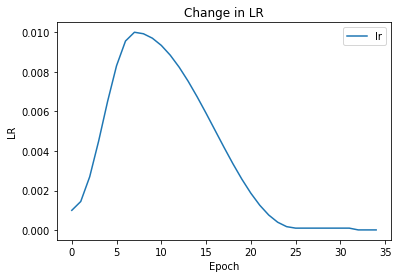

In [14]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

## Plot Validation Loss

Plot the change in validation loss vs epochs

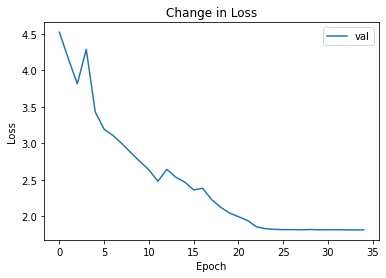

In [10]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

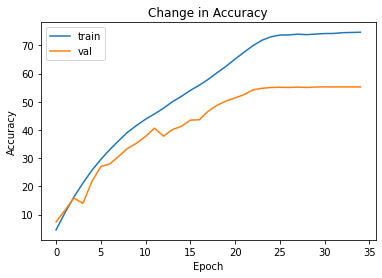

In [11]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

## Visualize GradCAM

Use GradCAM to understand where the network is looking at while prediction

In [0]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCAM for incorrectly classified images

Layer wise visualization of GradCAM for misclassified images

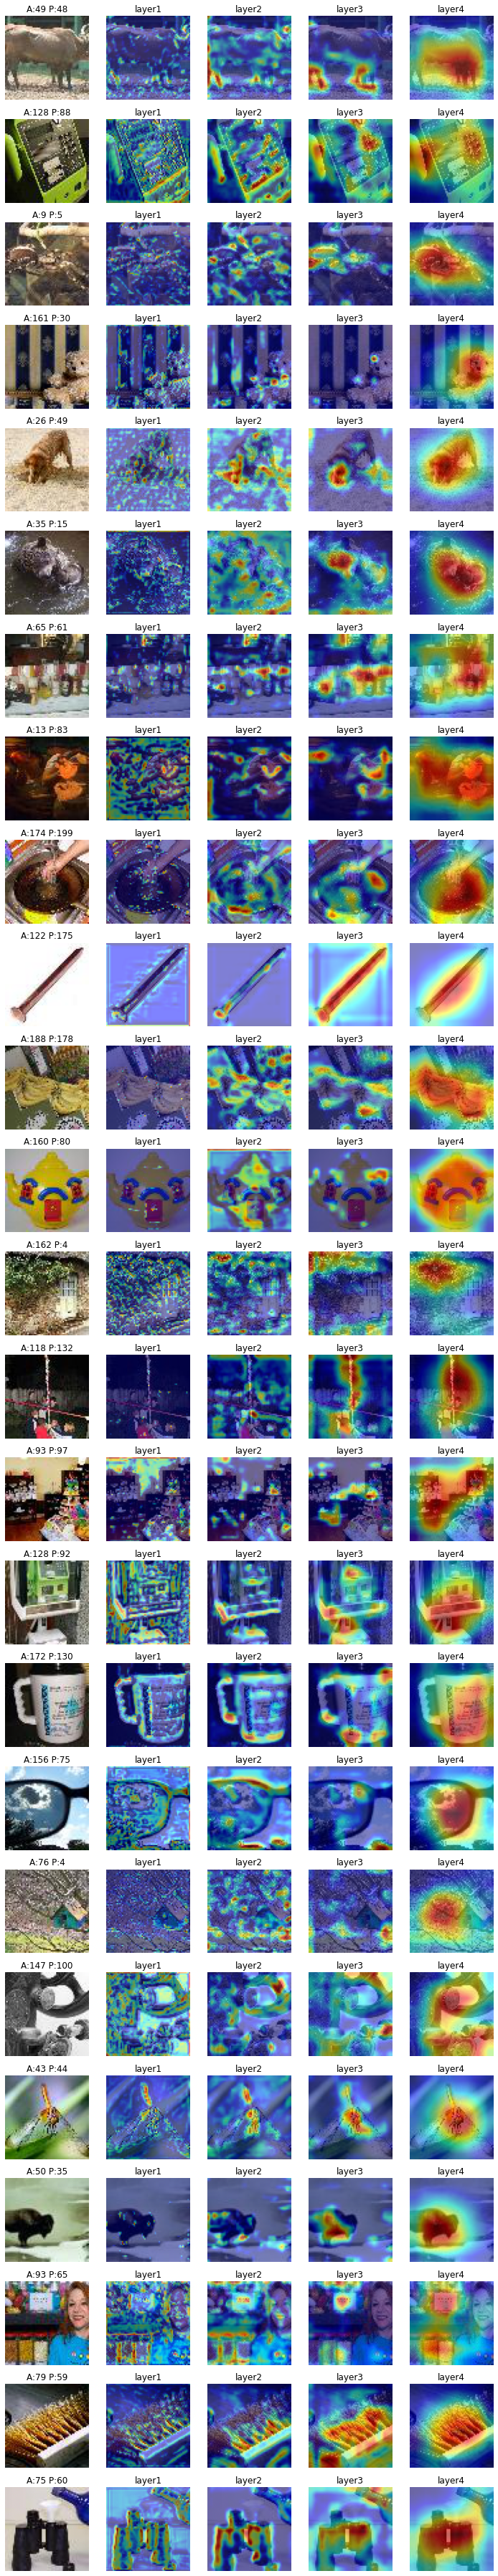

In [13]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)